# Digitalt Spektrum

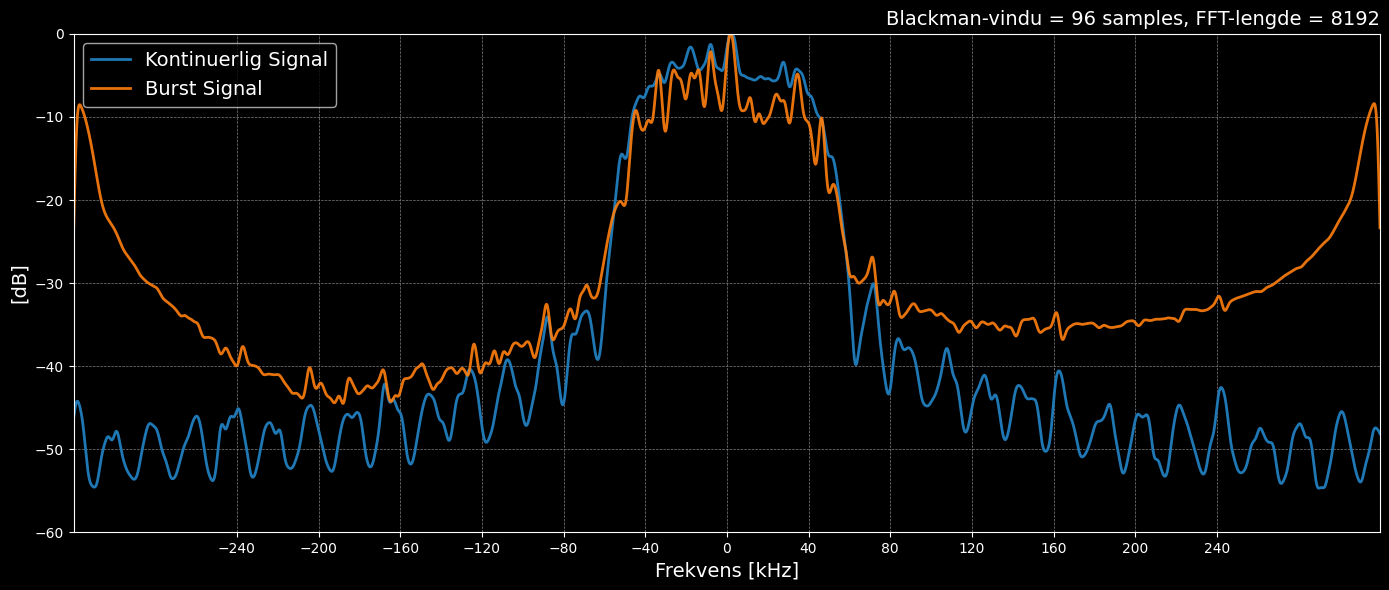

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')

# === PARAMETRE ===
filnavn_kont = 'SimData/TxKontData.bin'
filnavn_burst = 'SimData/TxBurstData.bin'
samp_rate = 640e3
fft_len = 8192                 # Endre for FFT-oppløsning
window_size = 96             # Glattingsvindu (antall samples)
window_func_name = 'blackman'     # Velg mellom: 'hann', 'blackman', 'hamming', 'bartlett', ...

# === VELG VINDUSFUNKSJON ===
window_functions = {
    'hann': np.hanning,
    'blackman': np.blackman,
    'hamming': np.hamming,
    'bartlett': np.bartlett
}

# Fallback hvis ukjent navn
window_func = window_functions.get(window_func_name.lower(), np.hanning)
filter_window = window_func(window_size)
filter_window /= filter_window.sum()

# === LAST INN DATA ===
kont_data = np.fromfile(filnavn_kont, dtype=np.complex64)
burst_data = np.fromfile(filnavn_burst, dtype=np.complex64)
t = np.arange(len(kont_data)) / samp_rate * 1000  # ms

# --- Funksjon for trygg log10-konvertering ---
def log_power_spectrum(spectrum):
    spectrum_magnitude = np.abs(spectrum)
    spectrum_magnitude[spectrum_magnitude == 0] = 1e-100  # Setter nullverdier til det minste positive tallet
    return 20 * np.log10(spectrum_magnitude)

# --- FFT og spektrum ---
spektrum_kont = np.fft.fftshift(np.fft.fft(kont_data, n=fft_len))
spektrum_kont_dB = log_power_spectrum(spektrum_kont)
spektrum_kont_dB = np.convolve(spektrum_kont_dB, filter_window, mode='same')
spektrum_kont_dB -= spektrum_kont_dB.max()

# --- Burst-spektrum ---
spektrum_burst = np.fft.fftshift(np.fft.fft(burst_data, n=fft_len))
spektrum_burst_dB = log_power_spectrum(spektrum_burst)
spektrum_burst_dB = np.convolve(spektrum_burst_dB, filter_window, mode='same')
spektrum_burst_dB -= spektrum_burst_dB.max()

freqs = np.fft.fftshift(np.fft.fftfreq(fft_len, 1/samp_rate)) / 1e3


# === PLOTTING ===
colors = ['tab:blue', 'tab:orange']
plt.figure(figsize=(14, 6))
plt.plot(freqs, spektrum_kont_dB, color=colors[0], label='Kontinuerlig Signal', linewidth=2)
plt.plot(freqs, spektrum_burst_dB, color=colors[1], label='Burst Signal', linewidth=2, alpha=0.9)

plt.annotate(f'{window_func_name.title()}-vindu = {window_size} samples, FFT-lengde = {fft_len}', 
             xy=(1, 1.01), xycoords='axes fraction', fontsize=14, ha='right', va='bottom')
plt.xlabel('Frekvens [kHz]', fontsize=14)
plt.ylabel('[dB]', fontsize=14)
plt.legend(loc='upper left', fontsize=14)
plt.xticks(np.arange(-240, 241, 40))
plt.xlim(min(freqs), max(freqs))
plt.yticks(np.arange(-60, 1, 10))
plt.ylim(-60, 0)
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig('Figurer/Tx_spektrum.pdf', format="pdf", bbox_inches='tight')
plt.show()

# Målt Spektrum

## Loop-back

Kontinuerlig utgangseffekt: -38.71 dBW
Burst utgangseffekt: -42.04 dBW


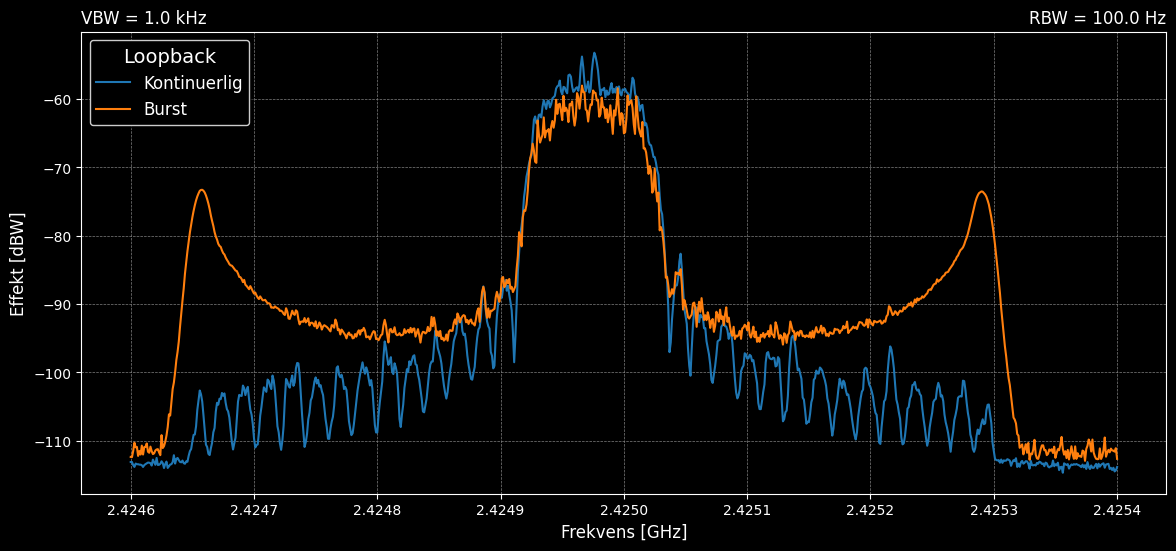

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')

file_paths = [
    "Måling/KontSpektrumLoopBack.csv",
    "Måling/BurstSpektrumLoopBack.csv",]

RBW = 100 # Hz
VBW = 1000 # Hz

columns = ['Power [dBW]', 'Frequency[Hz]']
spektrum = {}
keys = ['Kontinuerlig', 'Burst']
spektrum = {key: pd.DataFrame() for key in keys}
for file_path, key in zip(file_paths, keys):
    spektrum[key] = pd.read_csv(file_path, sep=',', names=columns, skiprows=154)
    spektrum[key]['Frequency[GHz]'] = spektrum[key]['Frequency[Hz]'] / 1e9
    spektrum[key]['Power [dBW]'] = spektrum[key]['Power [dBW]'] + 30 # Attenuator + 30 dB


utgangseffekt = {'PlutoK': 0, 'PlutoM': 0} # dBm
for key in keys:
    utgangseffekt[key] = 10* np.log10(np.sum(10 ** (spektrum[key]['Power [dBW]'] / 10)))
    print(f'{key} utgangseffekt: {utgangseffekt[key]:.2f} dBW')

colors = ['tab:blue', 'tab:orange']
plt.figure(figsize=(14,6))
for key, color in zip(keys, colors):
    plt.plot(spektrum[key]['Frequency[GHz]'], spektrum[key]['Power [dBW]'], linestyle='-', color=color, label=key)

        
plt.annotate('RBW = {:.1f} Hz'.format(RBW), xy=(1, 1.01), xycoords='axes fraction', fontsize=12, ha='right', va='bottom')
plt.annotate('VBW = {:.1f} kHz'.format(VBW/1000), xy=(0, 1.01), xycoords='axes fraction', fontsize=12, ha='left', va='bottom')

#plt.xticks(np.arange(2.42475, 2.42525, 0.00005),)
#plt.yticks(np.arange(-135, -54, 5))
#plt.xlim(2.42475, 2.42525)
#plt.ylim(-135, -55)
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.ylabel('Effekt [dBW]', fontsize=12)
plt.xlabel('Frekvens [GHz]', fontsize=12)
plt.legend(loc='upper left', fontsize=12,title="Loopback", title_fontsize=14, shadow=True, fancybox=True)
plt.savefig('Figurer/LoopbackSpektrum.pdf', bbox_inches='tight')
plt.show()

## Antenne

Kontinuerlig utgangseffekt: -102.95 dBW
Burst utgangseffekt: -104.36 dBW


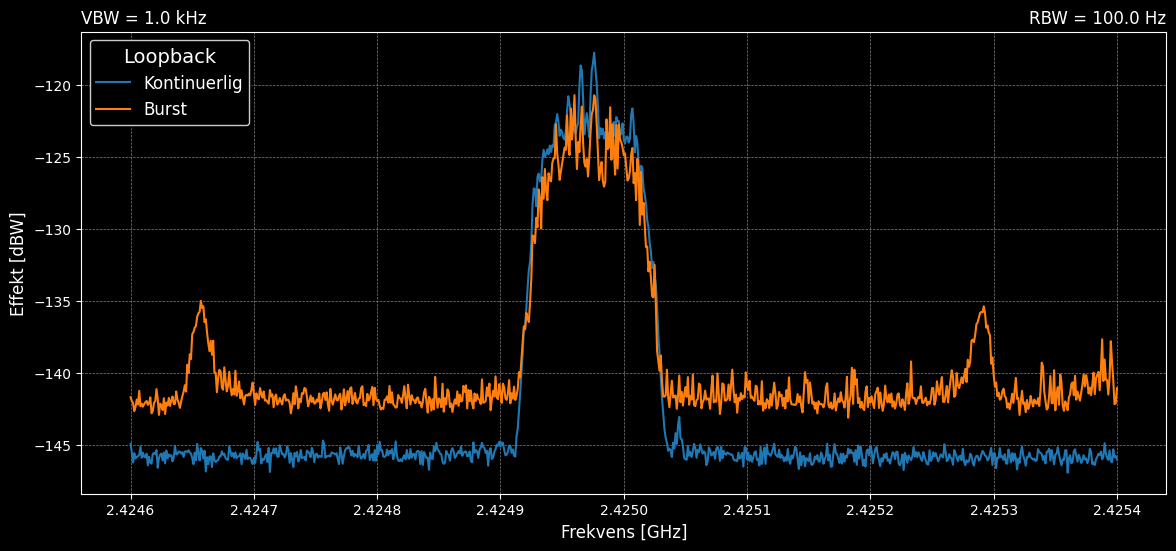

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')

file_paths = [
    "Måling/KontSpektrumAntenne.csv",
    "Måling/BurstSpektrumAntenne.csv",]

RBW = 100 # Hz
VBW = 1000 # Hz

columns = ['Power [dBW]', 'Frequency[Hz]']
spektrum = {}
keys = ['Kontinuerlig', 'Burst']
spektrum = {key: pd.DataFrame() for key in keys}
for file_path, key in zip(file_paths, keys):
    spektrum[key] = pd.read_csv(file_path, sep=',', names=columns, skiprows=154)
    spektrum[key]['Frequency[GHz]'] = spektrum[key]['Frequency[Hz]'] / 1e9
    spektrum[key]['Power [dBW]'] = spektrum[key]['Power [dBW]']


utgangseffekt = {'PlutoK': 0, 'PlutoM': 0} # dBm
for key in keys:
    utgangseffekt[key] = 10* np.log10(np.sum(10 ** (spektrum[key]['Power [dBW]'] / 10)))
    print(f'{key} utgangseffekt: {utgangseffekt[key]:.2f} dBW')

colors = ['tab:blue', 'tab:orange']
plt.figure(figsize=(14,6))
for key, color in zip(keys, colors):
    plt.plot(spektrum[key]['Frequency[GHz]'], spektrum[key]['Power [dBW]'], linestyle='-', color=color, label=key)

# bw_thresholds = [3, 6, 10, 15, 20, 25]
# for threshold in bw_thresholds:
#     for key, color in zip(keys, colors):
#         max_power = spektrum[key]['Power [dBW]'].rolling(window=150, center=True).mean().max() # Fjerner støy + peaks
#         threshold_power = max_power - threshold
#         # Find the frequency range where the power is above the threshold
#         mask = spektrum[key]['Power [dBW]'] >= threshold_power
#         freq_range = spektrum[key][mask]['Frequency[Hz]']
#         bw = freq_range.max() - freq_range.min()
        
#         if not freq_range.empty:
#             plt.plot(freq_range / 1e9, [threshold_power] * len(freq_range), linestyle='--', color=color, alpha=1)
#             if key == keys[0]:
#                 plt.annotate(f'{-threshold} dB: {bw/1e3:.1f} kHz', xy=(freq_range.iloc[0] / 1e9 - 0.000005, threshold_power), color=color, fontsize=8, ha='right', va='bottom')
#             elif key == keys[1]:
#                 plt.annotate(f'{-threshold} dB: {bw/1e3:.1f} kHz', xy=(freq_range.iloc[-1] / 1e9 + 0.000005, threshold_power), color=color, fontsize=8, ha='left', va='bottom')
# # Frekvens offset fra forventet LO-frekvens
# for key, color in zip(keys,colors):
#     # Calculate the mean power and frequency for each key
#     vindu = 400
#     f_max_index = spektrum[key]['Frequency[Hz]'][spektrum[key]['Power [dBW]'].rolling(window=vindu, center=True).mean() == spektrum[key]['Power [dBW]'].rolling(window=vindu, center=True).mean().max()].index[0]
#     f_max = spektrum[key]['Frequency[Hz]'][f_max_index]
#     f_c=2.425e9 # center frequency    
#     peak_offset = np.abs(f_max - f_c)/1e3
#     print(f'{key} peak offset: {peak_offset:.2f} kHz')
#     if key == keys[0]:
#         plt.annotate(r'$f_c$ offset$\approx$'+f'\n{peak_offset:.1f} kHz', xy=(f_max/1e9, -100), color=color, fontsize=10, ha='right', va='top')
#     elif key == keys[1]:
#         plt.annotate(r'$f_c$ offset$\approx$'+f'\n{peak_offset:.1f} kHz', xy=(f_max/1e9, -100), color=color, fontsize=10, ha='left', va='top')
        
    

plt.annotate('RBW = {:.1f} Hz'.format(RBW), xy=(1, 1.01), xycoords='axes fraction', fontsize=12, ha='right', va='bottom')
plt.annotate('VBW = {:.1f} kHz'.format(VBW/1000), xy=(0, 1.01), xycoords='axes fraction', fontsize=12, ha='left', va='bottom')

#plt.xticks(np.arange(2.42475, 2.42525, 0.00005),)
#plt.yticks(np.arange(-135, -54, 5))
#plt.xlim(2.42475, 2.42525)
#plt.ylim(-135, -55)
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.ylabel('Effekt [dBW]', fontsize=12)
plt.xlabel('Frekvens [GHz]', fontsize=12)
plt.legend(loc='upper left', fontsize=12,title="Loopback", title_fontsize=14, shadow=True, fancybox=True)
plt.savefig('Figurer/LoopbackSpektrum.pdf', bbox_inches='tight')
plt.show()

# Sinus Loopback

Peak offset: 5.50 kHz
Maximum power: -35.63 dBW
Maximum frequency: 2424984500.000000 GHz


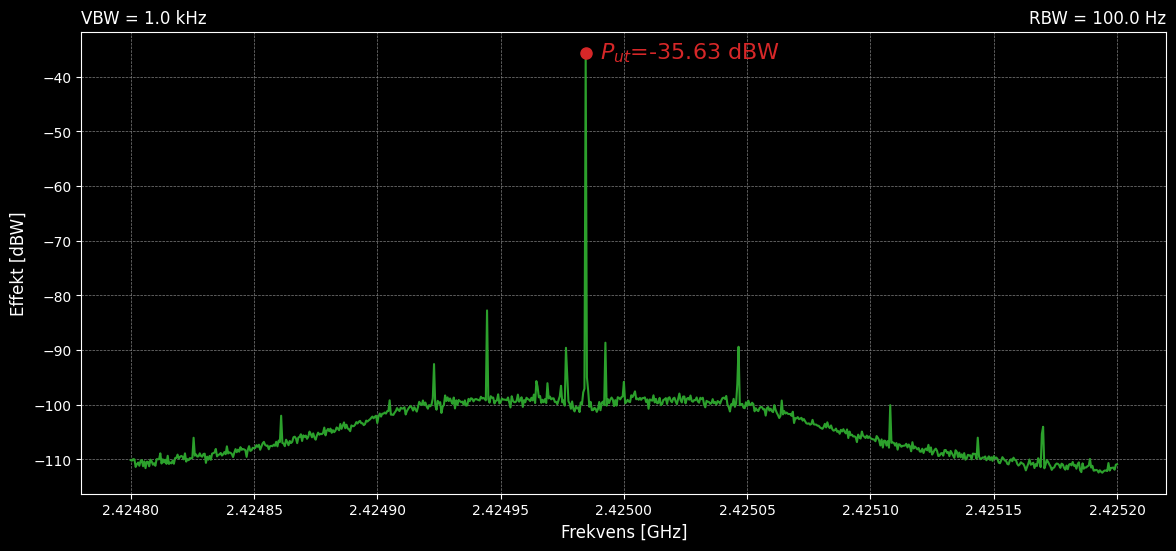

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')

filnavn="Måling/Sinus10kHz.csv"
RBW = 100 # Hz
VBW = 1000 # Hz

columns = ['Power [dBW]', 'Frequency[Hz]']
spektrum = pd.read_csv(filnavn, sep=',', names=columns, skiprows=154)
spektrum['Frequency[GHz]'] = spektrum['Frequency[Hz]'] / 1e9
spektrum['Power [dBW]'] = spektrum['Power [dBW]'] + 30  # Attenuator + 30 dB

# Find maximum power and frequency at the peak
max_power = spektrum['Power [dBW]'].max()  # Fjerner støy + peaks
max_power_index = spektrum['Power [dBW]'].idxmax()
max_freq = spektrum['Frequency[Hz]'][max_power_index]

f_c = 2.425e9  # center frequency
f_expected = 2.425e9 - 10e3  # expected frequency
peak_offset = np.abs(max_freq - f_expected) / 1e3  # kHz
print(f'Peak offset: {peak_offset:.2f} kHz')
print(f'Maximum power: {max_power:.2f} dBW')
print(f'Maximum frequency: {max_freq:.6f} GHz')
plt.figure(figsize=(14,6))
plt.plot(spektrum['Frequency[GHz]'], spektrum['Power [dBW]'], linestyle='-', color='tab:green', label='10 kHz Sinus')
plt.plot(max_freq / 1e9, max_power, 'o', color="tab:red",markersize=8)
plt.annotate(r'$P_{ut}$=' + f'{max_power:.2f} dBW', xy=(max_freq / 1e9, max_power), xytext=(10, 0), textcoords='offset points', color="tab:red", fontsize=16, ha='left', va='center')

plt.annotate('RBW = {:.1f} Hz'.format(RBW), xy=(1, 1.01), xycoords='axes fraction', fontsize=12, ha='right', va='bottom')
plt.annotate('VBW = {:.1f} kHz'.format(VBW/1000), xy=(0, 1.01), xycoords='axes fraction', fontsize=12, ha='left', va='bottom')

plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.ylabel('Effekt [dBW]', fontsize=12)
plt.xlabel('Frekvens [GHz]', fontsize=12)

plt.show()

